<a href="https://colab.research.google.com/github/shere-khan/machine_learning/blob/master/SimpleRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

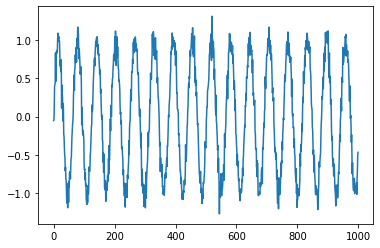

In [65]:
# make the synthetic data
N = 1000
series = np.sin(.1 * np.arange(N)) + np.random.randn(N) * .1

# plot it
plt.plot(series)
plt.show()

In [66]:
# build the dataset
# lets see if iwe can use T past values to predict the next value
T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print(f'X.shape {X.shape} Y.shape {Y.shape}')

X.shape (990, 10, 1) Y.shape (990, 1)


In [67]:
# set device
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [68]:
class SimpleRNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(SimpleRNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    # note: batch_first=True
    # applies the convention that our data will be of
    # shape: (num_samples, seq_length, num_feat)
    # rather than: (seq_length, num_samp, num_feat)
    self.rnn = nn.RNN(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        nonlinearity='relu',
        batch_first=True # N-dimension comes first
    )
    self.fc = nn.Linear(self.M, self.K)

  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # get RNN unit output
    # out is of size (N, T, M)
    # 2nd return value is hidden states
    # at each hidden layer
    # we don't need those now
    out, _ = self.rnn(X, h0)

    # we only want hidden state h(T)
    # corresponding to the final time step
    out = self.fc(out[:, -1, :])
    return out

In [69]:
# instantiate model
model = SimpleRNN(n_inputs=1, n_hidden=5, n_rnnlayers=1, n_outputs=1)
model.to(device)

SimpleRNN(
  (rnn): RNN(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [70]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.1)

In [71]:
# make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [72]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [73]:
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=200):

  # stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    train_losses[it] = loss.item()
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()

    if (it + 1) % 5 == 0:
      print(f"""Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}""")

  return train_losses, test_losses

In [74]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/200, Train Loss: 0.2181, Test Loss: 0.1282
Epoch 10/200, Train Loss: 0.0866, Test Loss: 0.1084
Epoch 15/200, Train Loss: 0.0867, Test Loss: 0.0809
Epoch 20/200, Train Loss: 0.0581, Test Loss: 0.0483
Epoch 25/200, Train Loss: 0.0389, Test Loss: 0.0338
Epoch 30/200, Train Loss: 0.0319, Test Loss: 0.0308
Epoch 35/200, Train Loss: 0.0271, Test Loss: 0.0268
Epoch 40/200, Train Loss: 0.0244, Test Loss: 0.0261
Epoch 45/200, Train Loss: 0.0245, Test Loss: 0.0265
Epoch 50/200, Train Loss: 0.0240, Test Loss: 0.0258
Epoch 55/200, Train Loss: 0.0242, Test Loss: 0.0256
Epoch 60/200, Train Loss: 0.0236, Test Loss: 0.0251
Epoch 65/200, Train Loss: 0.0235, Test Loss: 0.0252
Epoch 70/200, Train Loss: 0.0234, Test Loss: 0.0250
Epoch 75/200, Train Loss: 0.0233, Test Loss: 0.0249
Epoch 80/200, Train Loss: 0.0231, Test Loss: 0.0248
Epoch 85/200, Train Loss: 0.0231, Test Loss: 0.0248
Epoch 90/200, Train Loss: 0.0230, Test Loss: 0.0247
Epoch 95/200, Train Loss: 0.0230, Test Loss: 0.0247
Epoch 100/200

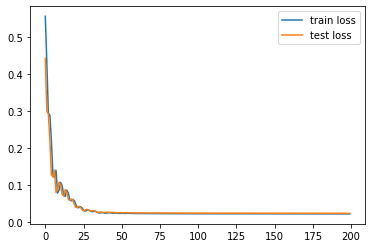

In [75]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [76]:
# "wrong" forecast using true targets

validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = 0

while len(validation_predictions) < len(validation_target):
  input_ = X_test[i].view(1, T, 1)
  p = model(input_)[0,0].item() # 1x1 array -> scalar
  i += 1

  # update the predictions list
  validation_predictions.append(p)

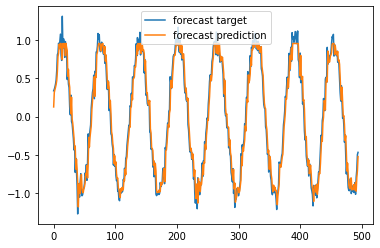

In [77]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [78]:
# forecast future values (use only self-predictions for making future predictions)

validation_target = Y[-N//2:]
validation_predictions = []

# last train input
# 1-D array of length T
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
  input_ = last_x.view(1, T, 1)
  p = model(input_)

  # update the predictions list
  validation_predictions.append(p[0,0].item())

  # make the new input
  last_x = torch.cat((last_x[1:], p[0]))


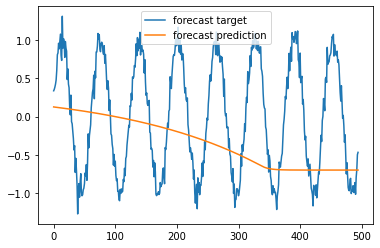

In [79]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()